This Jupyter Notebook is meant to be an introduction to loading data into Xarray, and how to perform simple tasks like removing the climatology from a global field. I will then demonstrate how to visualize the output of your calculations using Cartopy.

In [1]:
import xarray as xr
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cartopy
import cartopy.crs as ccrs

import cmocean as cm

In [2]:
#variable files on disk
t_file = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/t_7917.nc'

#set colormap
colormap = cm.cm.balance

In [3]:
#load xarray Datasets
var = xr.open_dataset(t_file)

#only for temp: convert from kelvin to celcius
var['t'] = var.t - 273.15

#calculate seasonal cycles
var_climatology = var.t.groupby('time.month').mean(axis=0)

# #calculate normalized data
var_anomaly = var.t.groupby('time.month') - var_climatology

# #convert to array for computation
var_anom = np.array(var_anomaly.to_masked_array())

#save the temperature array to file
np.save('t_anom_7917.npy', np.array(var_anom))

/home/jakidxav/anaconda3/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


A note about the way I saved the anomaly matrices: you lose the metadata when you save a field as a NumPy array. The reason I am doing this is because I feel more comfortable in NumPy land, especially when I am doing more complicated analyses. ow

However, the alternative to removing the annual cycle in NumPy is no where near as elegant and easy to understand as it is in Xarray. I processed all of the variables that I am going to do in this analysis in Xarray, so when you see anomaly fields this is where the data came from.

In [4]:
#let's see if our data has the right dimensions
print(var_anom.shape)

(468, 37, 121, 240)


In [5]:
#and now for the metadata
print(var_anomaly)

<xarray.DataArray 't' (time: 468, level: 37, latitude: 121, longitude: 240)>
array([[[[11.909197, ..., 11.909197],
         ...,
         [-3.105474, ..., -3.105474]],

        ...,

        [[-2.226795, ..., -2.226795],
         ...,
         [ 0.694366, ...,  0.694366]]],


       ...,


       [[[ 0.633921, ...,  0.633921],
         ...,
         [-0.138371, ..., -0.138371]],

        ...,

        [[ 5.743923, ...,  5.743923],
         ...,
         [-0.701736, ..., -0.701736]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12


So our data has the dimensions (time, pressure, latitude, longitude). The time variable is for 12 months x 39 years. The latitude and longitude are at 1.5 degree resolution.

Below, I am going to show how easy it is to integrate Cartopy with Xarray for visualizing output.

In [6]:
"""
Input a variable, selecting for time and pressure. Output a global field for a given projection.
Based in part on this tutorial: 
https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
"""
def plot_xarray(var, time, pressure, vmin, vmax, norm, cmap, proj, trans):
    #define figure and axis
    fig = plt.figure(figsize=(15, 15))
    
    #https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
    ax = plt.axes(projection=proj)
    
    #lets plot continental coastlines
    ax.coastlines()
    ax.gridlines()
    
    #now plot the actual field
    var[time, pressure].plot(transform=trans, vmin=vmin, 
                             vmax=vmax, cmap=cmap, ax=ax, cbar_kwargs={'shrink': 0.4})
    
    plt.show()

In [7]:
var_anomaly

<xarray.DataArray 't' (time: 468, level: 37, latitude: 121, longitude: 240)>
array([[[[11.909197, ..., 11.909197],
         ...,
         [-3.105474, ..., -3.105474]],

        ...,

        [[-2.226795, ..., -2.226795],
         ...,
         [ 0.694366, ...,  0.694366]]],


       ...,


       [[[ 0.633921, ...,  0.633921],
         ...,
         [-0.138371, ..., -0.138371]],

        ...,

        [[ 5.743923, ...,  5.743923],
         ...,
         [-0.701736, ..., -0.701736]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

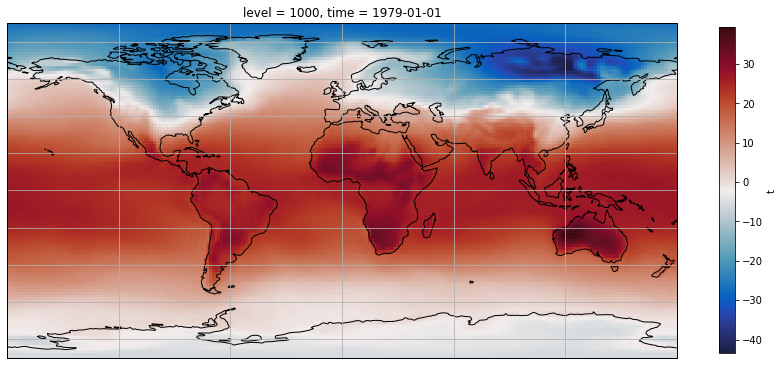

In [8]:
#let's plot the surface temperature
proj = ccrs.PlateCarree()
trans = ccrs.PlateCarree()

lon_list = var.longitude
lat_list = var.latitude

vmin = float(np.min(var.t[0, 36]))
vmax = float(np.max(var.t[0, 36]))

Norm = mpl.colors.Normalize(vmin=-44., vmax=44.)

plot_xarray(var.t, 0, 36, vmin, vmax, Norm, colormap, proj, trans)

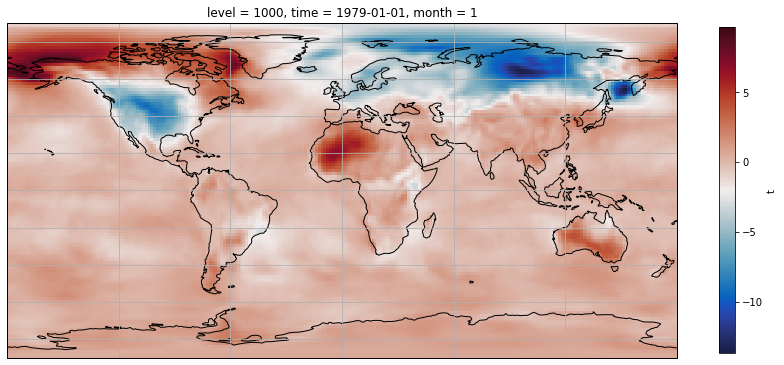

In [9]:
#let's plot the surface temperature anomaly
vmin2 = float(np.min(var_anomaly[0, 36]))
vmax2 = float(np.max(var_anomaly[0, 36]))

Norm2 = mpl.colors.Normalize(vmin=-14., vmax=14.)

plot_xarray(var_anomaly, 0, 36, vmin2, vmax2, Norm2, colormap, proj, trans)

We could do more to customize the plot, like adding units for our colorbar, pretty printing our title, selecting for specific latitudes and longitudes, labelling our gridlines, or changing the central longitude to look at the Pacific Ocean (which I do in later Notebooks). This was meant to be an introduction to Xarray and Cartopy. While I will shift back to NumPy, I will continue to use Cartopy throughout the rest of this project.